In [1]:
#mengaitkan gdrive dengan google colab
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
import os, sys
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
import pandas as pd
from imutils import paths
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [3]:
data_dir = '/content/drive/MyDrive/RISET PAPER AUG/Hasil Aug/Training'

#memanggil seluruh citra dan menampungnya ke dalam array yang sudah disediakan, serta merize sesuai kebutuhan
datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_std_normalization= True,
                                   validation_split=0.2)

train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(300, 300),
                                              batch_size= 32,
                                              class_mode= 'categorical',
                                              shuffle= True,
                                              subset='training')

validation_generator = datagen.flow_from_directory(data_dir,
                                                   target_size=(300, 300),
                                                   batch_size= 32,
                                                   class_mode= 'categorical',
                                                   subset='validation')

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 3840 images belonging to 6 classes.
Found 960 images belonging to 6 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/SHEAR AUG BATIK/DATA TEST',
                                            target_size = (300, 300),
                                            shuffle= False,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 300 images belonging to 6 classes.


In [5]:
class_indices = train_generator.class_indices
print (class_indices)

{'Ceplok': 0, 'Kawung': 1, 'Megamendung': 2, 'Nitik': 3, 'Parang': 4, 'Tambal': 5}


In [6]:
labels_train= train_generator.classes
print(labels_train)

[0 0 0 ... 5 5 5]


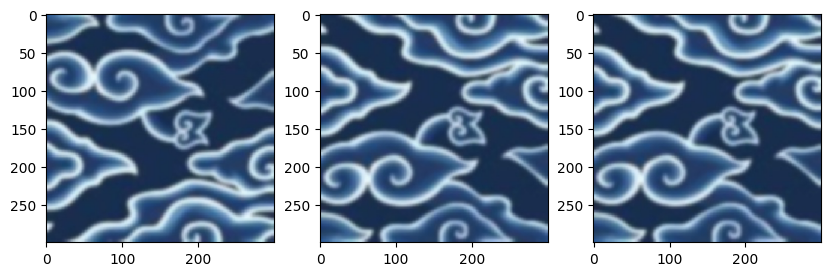

In [7]:
#Menampilkan data prepocessing
image_path = '/content/drive/MyDrive/RISET PAPER AUG/Hasil Aug/Training/Megamendung/NonGMB_Aug_10.jpg'

img = keras.preprocessing.image.load_img(image_path, target_size= (300, 300))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip= True)
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size = 32)
plt.figure(figsize=(10,10))

#Plots our figures
for i in range(1,4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()

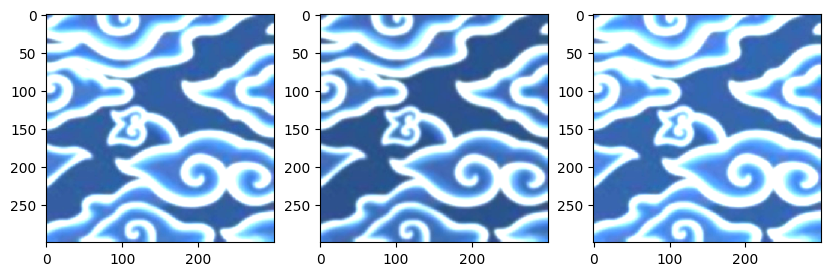

In [8]:
#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(brightness_range=[0.1, 2.5])
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size = 32)
plt.figure(figsize=(10,10))

#Plots our figures
for i in range(1, 4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()

In [9]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import tensorflow as tf


model = tf.keras.Sequential([
    ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(300, 300, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax', name='classification')
])

234545216/234545216 [==============================] - 1s 0us/step


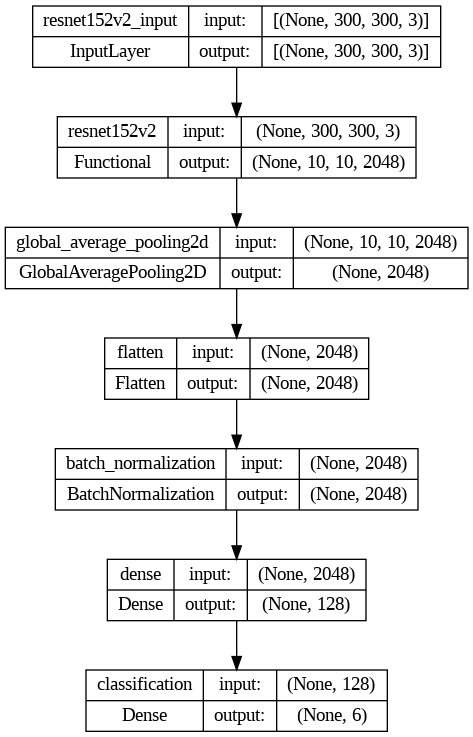

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
model.summary()
plt.savefig("ModelSummary.jpg")
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 classification (Dense)      (None, 6)                 7

<Figure size 640x480 with 0 Axes>

In [12]:
# Compile the Neural network
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

filepath = 'model_Batik.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 10)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, es]

In [14]:
#save the model history in a list after fitting so taht we can plot later
model_history = []
history = model.fit(
        train_generator,
        validation_data=validation_generator,
        batch_size= 32,
        epochs=100,
        callbacks=[checkpoint, es])

# Evaluasi model pada data pelatihan
train_score = model.evaluate(train_generator)
print('Train Score:', train_score)

val_score = model.evaluate(validation_generator)
print('Val Score:', val_score)

test_score = model.evaluate(test_set)
print('Test Score:', test_score)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.9026
Epoch 1: val_loss improved from inf to 0.17368, saving model to model_Batik.h5
120/120 [==============================] - 788s 6s/step - loss: 0.3240 - accuracy: 0.9026 - val_loss: 0.1737 - val_accuracy: 0.9812
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9924
Epoch 2: val_loss improved from 0.17368 to 0.03423, saving model to model_Batik.h5
120/120 [==============================] - 174s 1s/step - loss: 0.0456 - accuracy: 0.9924 - val_loss: 0.0342 - val_accuracy: 0.9979
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9966
Epoch 3: val_loss improved from 0.03423 to 0.01702, saving model to model_Batik.h5
120/120 [==============================] - 182s 2s/step - loss: 0.0219 - accuracy: 0.9966 - val_loss: 0.0170 - val_accuracy: 0.9990
Epoch 4/100
120/120 [==============================] - ETA: 0s - los

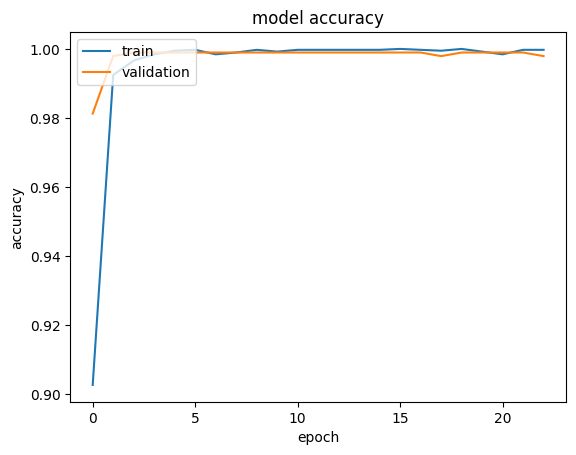

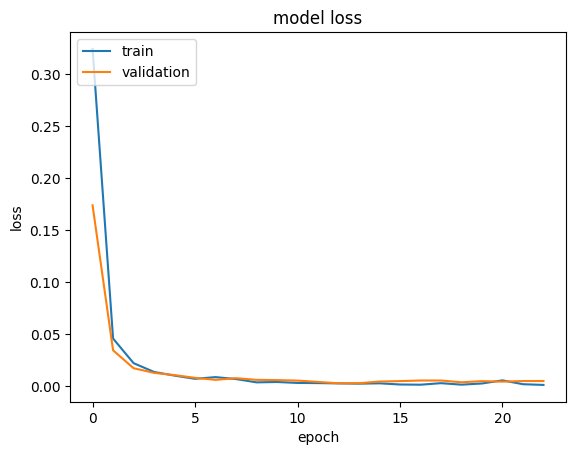

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
# Prediksi label menggunakan model
y_pred = model.predict_generator(test_set, steps=len(test_set))

# Ambil label yang sebenarnya
y_true = test_set.classes

<ipython-input-16-bb0447526716>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_set, steps=len(test_set))


[[14  4  9  3  0 20]
 [ 0 48  2  0  0  0]
 [ 0  0 47  0  3  0]
 [ 1  0  5 42  2  0]
 [ 0  0  0  0 50  0]
 [ 0  0  0  0  1 49]]


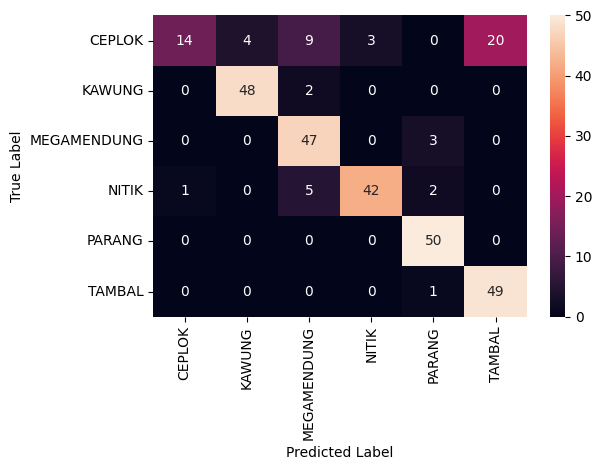

In [17]:
# Hitung confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print(conf_matrix)


df_cm = pd.DataFrame(conf_matrix, index= test_set.class_indices, columns= test_set.class_indices)

# plot confusion matrix using seaborn heatmap
sns.heatmap(df_cm, annot=True, fmt= 'd')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [18]:
# Step 1: Predict on test data
y_pred_prob = model.predict_generator(test_set)

# Step 2: Get class with highest probability
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 3: Calculate accuracy score
from sklearn.metrics import accuracy_score
y_true = test_set.classes
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

<ipython-input-18-4c125e6a6fc1>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_set)


Accuracy: 0.8333333333333334


In [19]:
# membuat classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=test_set.class_indices)

print(report)

              precision    recall  f1-score   support

      CEPLOK       0.93      0.28      0.43        50
      KAWUNG       0.92      0.96      0.94        50
 MEGAMENDUNG       0.75      0.94      0.83        50
       NITIK       0.93      0.84      0.88        50
      PARANG       0.89      1.00      0.94        50
      TAMBAL       0.71      0.98      0.82        50

    accuracy                           0.83       300
   macro avg       0.86      0.83      0.81       300
weighted avg       0.86      0.83      0.81       300



(1, 300, 300, 3)
1/1 [==============================] - 4s 4s/step
[[3.6463025e-05 1.8796498e-05 1.6588927e-05 2.5493122e-05 4.8276943e-06
  9.9989772e-01]]
5
Tambal


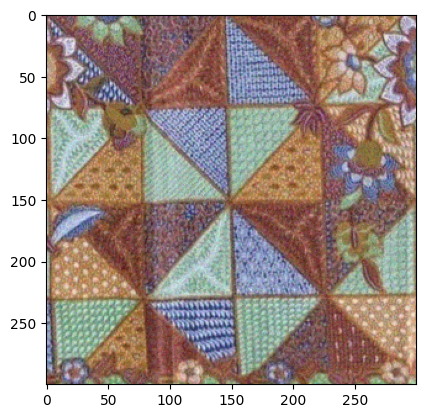

In [20]:
from PIL import Image
import numpy as np
from keras.models import load_model


classes = ['Ceplok', 'Kawung', 'Megamendung', 'Nitik', 'Parang', 'Tambal']
loaded_model = load_model ('model_Batik.h5')

image_testing = Image.open('/content/drive/MyDrive/RISET PAPER AUG/Hasil Aug/Testing/Tambal/NonGMB_Aug_12.jpg')
image_testing = np.array(image_testing.resize((300, 300)))/255.0
plt.imshow(image_testing)
image_testing.shape

image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

output = model.predict(image_testing)
best_index = np.argmax(output)
class_name = classes[best_index]

print(output)
print(best_index)

print(classes[best_index])